In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from collections import defaultdict
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
from matplotlib.patches import Circle
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Flatten, Reshape, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2
import time
import keras.backend as K
from keras.callbacks import Callback, TensorBoard, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import Input
from tensorflow.keras.utils import Sequence, to_categorical, plot_model

Using TensorFlow backend.


In [2]:
pathToTxt = "ImageSets/Main"
filesToOmit = ["train.txt", "val.txt", "trainval.txt", "test.txt"]
txtList = np.sort([txtFile for txtFile in os.listdir(pathToTxt) if txtFile not in filesToOmit])

In [3]:
# a method to load train/val/trainval files
def getFileID_byType(fileName):
    path = os.path.join(pathToTxt , fileName)
    fileIDs = np.loadtxt(path, dtype=str)
    return fileIDs

In [4]:
#iterate through train/val/trianval text files and filter only the needed 4 classes
dataDict = {}
validClasses = ["aeroplane", "car", "cat", "dog"]

for cls in validClasses:
    trainpath = cls + "_train.txt"
    trainvalpath = cls + "_trainval.txt"
    valpath = cls + "_val.txt"
    fileIDs_byType = {}
    
    fileIDs_byType["train"] = getFileID_byType(trainpath)
    fileIDs_byType["trainval"] = getFileID_byType(trainvalpath)
    fileIDs_byType["val"] = getFileID_byType(valpath)
    
    dataDict[cls] = fileIDs_byType

In [5]:
# dataDict #print for sanity check

In [6]:
copied_dataDict = dataDict.copy() #copy dictionary  
#iterate through all dictionry entries and filter OUT the -1 entries 
#np.where to keep entries/files where a class out of the 4 classes exist
for validClass in validClasses: 
    databyType = copied_dataDict[validClass]
    for type1 in databyType:
        data = databyType[type1]
        databyType[type1] = data[np.where(data[:,1] == "1")]
    copied_dataDict[validClass] = databyType 

In [7]:
# copied_dataDict 

## Parse and modify corresponding XML files

In [8]:
# a method to delete irrelevant objects' information from XML files 
def deleteClasses(filename, classes):
    path = "Annotations/" + filename
    tree = ET.parse(path)
    root = tree.getroot()
    for obj in root.iter('object'):
        if obj.find('name').text not in classes:
            root.remove(obj)

In [9]:
#Data structure:Nested Dict:
#                           Class: aeroplane, car, cat, dog
#                                 filetype: train/val/trainval
#                                           fileID: file name
                
for cls in copied_dataDict:
    filebytype = copied_dataDict[cls]
    for _type in filebytype:
        fileIds = filebytype[_type]
        for ID in fileIds:
            deleteClasses(ID[0] + ".xml", validClasses)

In [10]:
#method to detele entries that contain a single object using the child/branch in XML files
def reduceSetToSingleObjects(filename):
    path = "new_annotations/" + filename
    tree = ET.parse(path)
    root = tree.getroot()
    if len(root.findall('object')) > 1:
        os.remove(path)

In [11]:
for file in os.listdir("new_annotations"):
    reduceSetToSingleObjects(file)

## Find Centerpoints

In [12]:
#Calculate the center point from bounding box coordinates
def findCenterPoint(xmin, xmax, ymin, ymax):
#     print(xmin + xmax / 2, ymin + ymax/2 )
    xcoord = int((xmax + xmin) / 2)
    ycoord = int((ymax + ymin) / 2)
    return (xcoord , ycoord)

In [13]:
#iterate through xml files in the new_annotations directory and calcualte centerpoints 
centerpoints = []
for file in os.listdir("new_annotations"):
    path = "new_annotations/" + file
    tree = ET.parse(path)
    root = tree.getroot()
    obj = root.find('object')
    if obj.find("name").text == "aeroplane":
        classNum = 0
    elif obj.find("name").text == "car":
        classNum = 1
    elif obj.find("name").text == "cat":
        classNum = 2
    elif obj.find("name").text == "dog":
        classNum = 3
#     print(obj.find("name").text)
    bndbox = obj.find('bndbox')
    classNum
    xmin = int(bndbox.find("xmin").text)
    xmax = int(bndbox.find("xmax").text)
    ymin = int(bndbox.find("ymin").text)
    ymax = int(bndbox.find("ymax").text)
    cords = findCenterPoint(xmin, xmax, ymin, ymax)
    centerpoints.append([file, cords, classNum])

In [14]:
np.save('centerpoints.npy', centerpoints) #save as numpy array to avoid future calculations 

In [15]:
b = np.load('centerpoints.npy', allow_pickle=True)

In [16]:
b

array([['2008_000824.xml', (220, 203), 2],
       ['2008_003420.xml', (217, 203), 2],
       ['2008_004752.xml', (175, 206), 3],
       ...,
       ['2009_001201.xml', (206, 169), 3],
       ['2009_001286.xml', (279, 188), 3],
       ['2008_005016.xml', (235, 286), 3]], dtype=object)

## Visualize Data
Just to make sure centerpoints are correct

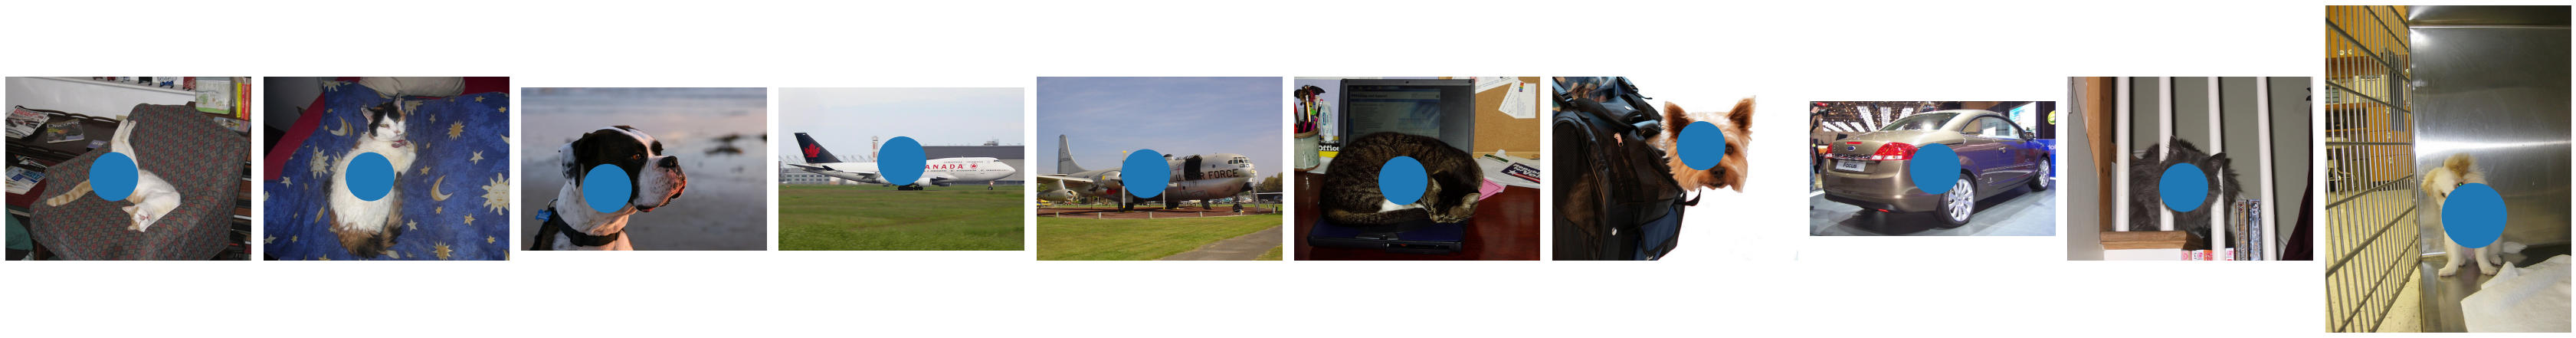

In [17]:
fig, axs = plt.subplots(nrows=1, ncols=10, figsize=(60, 15))
fig.subplots_adjust(left = None, right = None, bottom = None, top = None, hspace = 0.05, wspace=0.05)

for i in range(10):
    imagePath = "JPEGImages/" + centerpoints[i][0].split(".")[0] + ".jpg"
    coords = centerpoints[i][1]
    image = np.array(Image.open(imagePath))/255.
    axs[i].imshow(image, cmap = 'gray')
    circ = Circle(coords,50)
    axs[i].add_patch(circ)
    axs[i].axis('off')

## Build and train model

In [18]:
#load data the easy way #not randomized
# def loadData(dataDir, npyList, numCls, batchSize, inputSize):
#     image_dir = os.path.join(dataDir, "JPEGImages")
#     images = []
#     labels = []
#     for i in range (batchSize):
#         imagePath = "JPEGImages/" + npyList[i][0].split(".")[0] + ".jpg"
#         image = np.array(Image.open(imagePath).resize(inputSize))
# #         image = ((image - np.mean(image)) / (np.std(image))
#         label = npyList[i][1]
#         classNum = npyList[i][2]
#         images.append(image)
#         labels.append([label, classNum])
#         return np.array(images), np.array(labels) #, np.array(classNum)

In [19]:
#data generator
#includes pre-prcessing of the raw data
#resize, encode classes, normalization can be added here
#returns X_batch, and a dict for the two models {classifier: classes_batch(one_hot_encoded), detector:batch(coordicates)}

class dataGenn(Sequence):
    def __init__(self, npyList, batch_size):
        self.list = npyList
        self.batch_size = batch_size
        self.samples = len(self.list)
    def __len__(self):
        return int(np.ceil(len(self.list) / float(self.batch_size)))
 
    def __getitem__(self, idx):
        idx = np.random.randint(0, self.samples, self.batch_size)
        batch_x, batch_y, batch_classes= [], [] , []
        for i in idx:
            imagePath = "JPEGImages/" + self.list[i][0].split(".")[0] + ".jpg"
            _image = image = np.array(Image.open(imagePath).resize(inputSize))
            _label = self.list[i][1]
            _classNum = self.list[i][2]
            one_hot_label = to_categorical(_classNum, num_classes= 4, dtype = 'float32')
            batch_classes.append(one_hot_label)
            batch_y.append(_label)
            batch_x.append(_image)
        return np.array(batch_x), {'classifier': np.array(batch_classes, dtype='float32' ), 'detector': np.array(batch_y, dtype='float32')}

In [20]:
#split the input data into train validation sets
#Create train and validation generators 
data = np.load('centerpoints.npy', allow_pickle=True)
trainData, testData = train_test_split(data,  test_size=0.10, random_state=42)
trainGen = dataGenn(trainData, batch_size = 20)
valGen = dataGenn(testData, batch_size = 20)

In [21]:
#Build class for the two-task two-loss model
class DetectClassify:
    
    @staticmethod
    def Classifier(inputs, numClasses): #this network is responsile for classifying the object in the image
        c1 = Conv2D(32, (3,3), activation='relu',padding='same')(inputs) 
        # c1 = tf.keras.layers.Dropout(0.1)(c1)
        c1 = BatchNormalization(axis=-1)(c1)
        c1 = Conv2D(32, (3,3), activation='relu',padding='same')(c1)
        c1 = BatchNormalization(axis=-1)(c1)
        p1 = MaxPooling2D(pool_size=(2, 2))(c1)
        ###############
        c2 = Conv2D(64, (3,3), activation='relu',padding='same')(p1)
        c2 = BatchNormalization(axis=-1)(c2)
        c2 = Conv2D(64, (3,3), activation='relu',padding='same')(c2)
        c2 = BatchNormalization(axis=-1)(c2)
        c2 = MaxPooling2D(pool_size=(2, 2))(c2)
        p2 = Dropout(0.25)(c2)
        #################
        c3 = Conv2D(128, (3,3), activation='relu',padding='same')(p2)
        c3 = BatchNormalization(axis=-1)(c3)
        c3 = Conv2D(128, (3,3), activation='relu',padding='same')(c3)
        c3 = BatchNormalization(axis=-1)(c3)
        c3 = MaxPooling2D(pool_size=(2, 2))(c3)
        p3 = Dropout(0.25)(c3)
        #################
        c4 = Conv2D(256, (3,3), activation='relu',padding='same')(p3)
        c4 = BatchNormalization(axis=-1)(c4)
        c4 = Conv2D(256, (3,3), activation='relu',padding='same')(c4)
        c4 = BatchNormalization(axis=-1)(c4)
        c4 = MaxPooling2D(pool_size=(2, 2))(c4)
        p4 = Dropout(0.25)(c4)
        ########################
        flat = Flatten()(p4)
        outputLayer = Dense(numClasses)(flat)
        outputLayer = Activation('softmax', name="classifier")(outputLayer)
        return outputLayer 
    
    @staticmethod
    def Detector(inputs):
        c0 = Conv2D(16, (3,3), activation='relu',padding='same')(inputs) 
        c0 = BatchNormalization(axis=-1)(c0)
#         c0 = Conv2D(16, (3,3), activation='relu',padding='same')(c0)
#         c0 = BatchNormalization(axis=-1)(c0)
        p0 = MaxPooling2D(pool_size=(2, 2))(c0)
        
        c1 = Conv2D(32, (3,3), activation='relu',padding='same')(p0)
#         c1 = BatchNormalization(axis=-1)(c1)
#         c1 = Conv2D(32, (3,3), activation='relu',padding='same')(c1)
#         c1 = BatchNormalization(axis=-1)(c1)
        p1 = MaxPooling2D(pool_size=(2, 2))(c1)
        ###############

        c2 = Conv2D(64, (3,3), activation='relu',padding='same')(p1)
        c2 = BatchNormalization(axis=-1)(c2)
#         c2 = Conv2D(64, (3,3), activation='relu',padding='same')(c2)
#         c2 = BatchNormalization(axis=-1)(c2)
        c2 = MaxPooling2D(pool_size=(2, 2))(c2)
        p2 = Dropout(0.25)(c2)
        #################
        c3 = Conv2D(128, (3,3), activation='relu',padding='same')(p2)
#         c3 = BatchNormalization(axis=-1)(c3)
#         c3 = Conv2D(128, (3,3), activation='relu',padding='same')(c3)
        c3 = BatchNormalization(axis=-1)(c3)
        c3 = MaxPooling2D(pool_size=(2, 2))(c3)
        p3 = Dropout(0.25)(c3)
        #################
        c4 = Conv2D(256, (3,3), activation='relu',padding='same')(p3)
#         c4 = BatchNormalization(axis=-1)(c4)
        c4 = Conv2D(256, (3,3), activation='relu',padding='same')(c4)
        c4 = BatchNormalization(axis=-1)(c4)
        c4 = MaxPooling2D(pool_size=(2, 2))(c4)
        p4 = Dropout(0.25)(c4)
        ########################
        flat = Flatten()(p4)
        output = Dense(2,name='detector')(flat)
        return output
    
    @staticmethod
    def BuildModel(imgW, imgH, numClasses):
        inputShape = (imgH, imgW, 3)
        chanDim = -1
        inputs = Input(shape=inputShape)
        classifier = DetectClassify.Classifier(inputs,numClasses)
        detector = DetectClassify.Detector(inputs)
        model = Model(inputs=inputs,outputs=[classifier, detector],name="DetectCalssify")
        
        return model

In [22]:
imgW=300
imgH=300 
inputSize = (imgW, imgH)
model = DetectClassify.BuildModel(imgW ,imgH, 4)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [23]:
# model.summary()

In [24]:
#my tensorflow did not like the keras 'root_mean_square_error' version.. so here is one
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

In [25]:
#define the loss function for each network/task 
#for classification we choose categorical_crossentropy since we have several categories. 
#for two categories we can change that to binary cross_entropy

#for the detection, since we are dealig with regression type of problem we choose a continuous type of loss RMSE is one
#adam for optimizer
losses={'classifier': 'categorical_crossentropy',  'detector': root_mean_squared_error}
model.compile(loss=losses, optimizer='adam')

In [26]:
#create callback for the training process. 
#save model weights every 10 epochs
#tensorboard for monitoring performance (not compatible with tensorflow 1.15, worked for 2.15)
#adjust learning rate when the loss functions hits a plateau
model_checkpoint = ModelCheckpoint("weights_train/weights.{epoch:02d}-{loss:.2f}.h5", monitor='loss', verbose=1, period=10) 
# tensorboard_callback = TensorBoard(log_dir="logdir/", write_graph=True, write_images=True, histogram_freq=1)
plateau_callback = ReduceLROnPlateau(monitor='loss', factor=0.99, verbose=1, patience=0, min_lr=0.00001) 
myCallbackss = [model_checkpoint, plateau_callback] #, tensorboard_callback]

In [27]:
# #start training process
# model.fit(trainGen, steps_per_epoch = 100,epochs = 1000, verbose = 1, validation_data =valGen,
#           validation_steps =100
#           ,callbacks= myCallbackss)

In [28]:
import tensorflow as tf
new_model = tf.keras.models.load_model('weights_train/weights.1000-4.74.h5',custom_objects={'root_mean_squared_error': root_mean_squared_error})

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [29]:
#A method to decode the predicted classes
#argmax to get the 1 index and convert the class number to string 
import tensorflow as tf
def decodeLabel(arr):
#     index = tf.argmax(arr[0], axis=1)
    npIndex = np.argmax(arr[0], axis=1) #index.numpy()
    if npIndex == 0:
        className = "aeroplane"
    elif npIndex == 1:
        className = "car"
    elif npIndex == 2:
        className = "cat"
    elif npIndex == 3:
        className = "dog"
    return className

In [36]:
#preprocess the test set where we on;y pick the xml/jpg files with valid classes
validClasses = ["aeroplane", "car", "cat", "dog"]
testList = np.loadtxt("ImageSets/Main/test.txt", dtype=str)
testfiles = []
for ID in testList:
    path = "Annotations/" + ID + ".xml"
    tree = ET.parse(path)
    root = tree.getroot()
    for obj in root.iter('object'):
        if obj.find('name').text in validClasses:
#             np.delete(testList,ID)
            print(obj.find('name').text)
            print(ID)
            testfiles.append(ID)

aeroplane
2008_000021
dog
2008_000026
car
2008_000027
car
2008_000042
car
2008_000050
car
2008_000052
cat
2008_000056
dog
2008_000059
cat
2008_000062
aeroplane
2008_000064
dog
2008_000078
dog
2008_000080
cat
2008_000115
cat
2008_000116
car
2008_000133
dog
2008_000138
car
2008_000163
car
2008_000174
car
2008_000174
car
2008_000174
car
2008_000174
car
2008_000174
car
2008_000174
cat
2008_000182
dog
2008_000183
car
2008_000203
cat
2008_000222
dog
2008_000239
aeroplane
2008_000251
aeroplane
2008_000251
aeroplane
2008_000251
car
2008_000251
car
2008_000253
car
2008_000261
dog
2008_000268
dog
2008_000270
car
2008_000278
car
2008_000281
car
2008_000281
car
2008_000304
car
2008_000304
car
2008_000304
car
2008_000304
car
2008_000304
cat
2008_000306
cat
2008_000345
cat
2008_000358
aeroplane
2008_000367
cat
2008_000401
dog
2008_000419
car
2008_000457
car
2008_000457
cat
2008_000464
car
2008_000501
cat
2008_000536
car
2008_000562
cat
2008_000581
car
2008_000599
car
2008_000599
car
2008_000599
car


cat
2008_007130
car
2008_007133
car
2008_007133
car
2008_007133
dog
2008_007163
car
2008_007163
car
2008_007163
cat
2008_007164
car
2008_007167
car
2008_007171
cat
2008_007176
car
2008_007181
cat
2008_007187
dog
2008_007187
aeroplane
2008_007195
car
2008_007195
car
2008_007214
cat
2008_007216
car
2008_007225
car
2008_007227
aeroplane
2008_007229
aeroplane
2008_007229
car
2008_007241
cat
2008_007256
car
2008_007264
cat
2008_007269
dog
2008_007279
dog
2008_007295
car
2008_007295
dog
2008_007311
car
2008_007311
car
2008_007314
car
2008_007314
car
2008_007314
car
2008_007314
car
2008_007314
car
2008_007314
car
2008_007323
cat
2008_007324
cat
2008_007327
dog
2008_007344
aeroplane
2008_007350
car
2008_007352
car
2008_007352
car
2008_007352
dog
2008_007358
aeroplane
2008_007374
dog
2008_007378
dog
2008_007384
car
2008_007389
cat
2008_007403
cat
2008_007404
cat
2008_007404
cat
2008_007404
aeroplane
2008_007409
car
2008_007409
car
2008_007409
dog
2008_007417
car
2008_007431
car
2008_007431
car


In [37]:
len(testList)

3581

In [38]:
np.array(testfiles, dtype= str).shape

(1731,)

In [39]:
#parse ground truths  from test set
def getGTs(ID):
    path = "Annotations/" + ID + ".xml"
    tree = ET.parse(path)
    root = tree.getroot()
    obj = root.find('object')
    if obj.find("name").text in validClasses:
        name = obj.find("name").text
    else: name = 'None'
    bndbox = obj.find('bndbox')
    xmin = int(bndbox.find("xmin").text)
    xmax = int(bndbox.find("xmax").text)
    ymin = int(bndbox.find("ymin").text)
    ymax = int(bndbox.find("ymax").text)
    cords = findCenterPoint(xmin, xmax, ymin, ymax)
    return [name, cords] 

In [40]:
#load images and perform predictions
predictedClasses = []
rmse_array = [] 
groundTruthClasses = []
for testID in testfiles:
    testImage = np.array(Image.open("JPEGImages/" + testID + ".jpg").resize(inputSize))
    testImage = testImage[np.newaxis ,...]
    groundTruth = getGTs(ID)
#     if groundTruth[0] != None:
    groundTruthClasses.append(groundTruth[0])
    prediction = new_model.predict(testImage)
    rmse = root_mean_squared_error(groundTruth[1], prediction[0][0][1])
    rmse_array.append(rmse)
    className = decodeLabel(prediction)
    predictedClasses.append(className)

ValueError: setting an array element with a sequence.

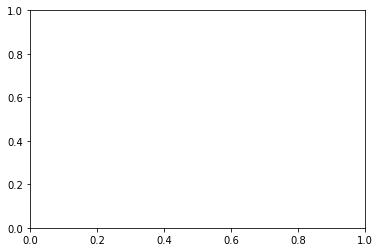

In [42]:
plt.plot(rmse_array)
plt.title('RMSE graph for predictions')

In [ ]:
from sklearn.metrics import confusion_matrix
confMatrix = confusion_matrix(groundTruthClasses, predictedClasses)

cm = confMatrix.astype('float') / confMatrix.sum(axis=1)[:, np.newaxis]

plt.imshow(cm,cmap = plt.cm.Blues)
tick_marks = np.arange(len(validClasses))
plt.xticks(tick_marks, validClasses, rotation=45)
plt.yticks(tick_marks, validClasses)

In [ ]:
#go into the test image directory to test the model and display the results.
testimages = os.listdir("testImages/")

fig, ax = plt.subplots(nrows=1, ncols=len(testimages), figsize=(60, 15))

for i in range(len(testimages)):
    testImage = np.array(Image.open("testImages/" + testimages[i]).resize(inputSize))
    testImage = testImage[np.newaxis ,...]
    result = model.predict(testImage)
    className = decodeLabel(result)
    ax[i].imshow(np.squeeze(testImage))
    circ = Circle(result[1][0],10)
    ax[i].add_patch(circ)
    ax[i].axis('off')
    ax[i].title.set_text(className)

In [ ]:
180-7